In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.simulate import simulate_networks
from inv_vae.utils.helpers import Namespace
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

simulate noise-free and noise-affected networks

In [3]:
seed = 666
n_nets = 1000
n_nodes = 68
p_in = .25
p_out = .01
n_noisy_nets = int(n_nets*.5)
noise_level = .6
noise_sd = .05

In [4]:
sim_nets, noisy_nets, noises, noise_ids = simulate_networks(n_nets=n_nets, n_nodes=n_nodes, p_in=p_in, p_out=p_out, seed=seed,
                                          n_noisy_nets=n_noisy_nets, noise_level=noise_level, noise_sd=noise_sd)
print(sim_nets.shape, noisy_nets.shape, noises.shape)

(1000, 68, 68) (1000, 68, 68) (1000,)


In [5]:
big_sim_nets = sim_nets[np.arange(n_noisy_nets)]
small_sim_nets = sim_nets[np.arange(n_noisy_nets, n_nets)]
diff_sim_nets = small_sim_nets.mean(0) - big_sim_nets.mean(0)

big_noise_nets = noisy_nets[np.arange(n_noisy_nets)]
small_noise_nets = noisy_nets[np.arange(n_noisy_nets, n_nets)]
diff_noise_nets = small_noise_nets.mean(0) - big_noise_nets.mean(0)

In [6]:
# PCA projections of noise-free and noise-affected networks for visualizations

pca = PCA(2)
sim_Xt = pca.fit_transform(sim_nets.reshape(-1, n_nodes*n_nodes))
noisy_Xt = pca.fit_transform(noisy_nets.reshape(-1, n_nodes*n_nodes))
sim_df = pd.DataFrame({"pc1": sim_Xt[:,0], "pc2": sim_Xt[:,1], "noise": noises})
noisy_df = pd.DataFrame({"pc1": noisy_Xt[:,0], "pc2": noisy_Xt[:,1], "noise": noises})

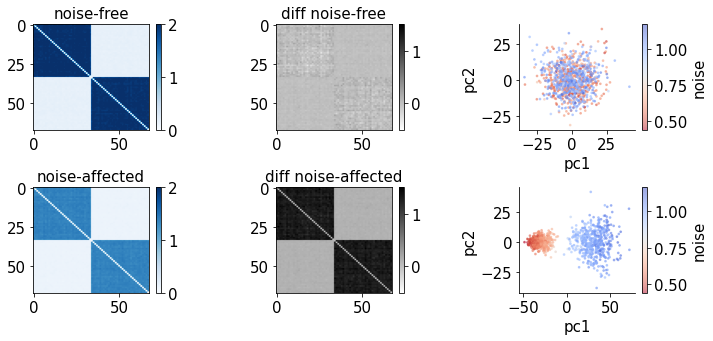

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

p1 = axes[0,0].imshow(sim_nets.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0,0].set_title('noise-free')
cbar = plt.colorbar(p1, ax=axes[0,0])

p2 = axes[0,1].imshow(diff_sim_nets, aspect='auto', cmap='binary', vmin=-0.5, vmax=1.5)
axes[0,1].set_title('diff noise-free')
cbar = plt.colorbar(p2, ax=axes[0,1])

p3 = axes[0,2].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm_r', data=sim_df, s=3, alpha=0.5)
axes[0,2].set_xlabel('pc1')
axes[0,2].set_ylabel('pc2')
axes[0,2].spines['top'].set_visible(False)
axes[0,2].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[0,2], label="noise")

p4 = axes[1,0].imshow(noisy_nets.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[1,0].set_title('noise-affected')
cbar = plt.colorbar(p4, ax=axes[1,0])

p5 = axes[1,1].imshow(diff_noise_nets, aspect='auto', cmap='binary', vmin=-0.5, vmax=1.5)
axes[1,1].set_title('diff noise-affected')
cbar = plt.colorbar(p5, ax=axes[1,1])

p6 = axes[1,2].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm_r', data=noisy_df, s=3, alpha=0.5)
axes[1,2].set_xlabel('pc1')
axes[1,2].set_ylabel('pc2')
axes[1,2].spines['top'].set_visible(False)
axes[1,2].spines['right'].set_visible(False)
cbar = plt.colorbar(p6, ax=axes[1,2], label="noise")

plt.tight_layout()
plt.show()

prepare torch datasets for training

In [8]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    alpha = 1, beta = .1, gamma = 1, add_reg = False, y_dim = 0, 
    batch_size=32, n_epochs=200, lr=2e-6, device=DEVICE)

In [9]:
ids = list(range(n_nets))
random.shuffle(ids)
train_ids = ids[:int(.9*n_nets)]
val_ids = ids[int(.9*n_nets):]
print(len(train_ids), len(val_ids))
tensor_nets = torch.stack([torch.Tensor(i) for i in list(noisy_nets)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_noises = torch.from_numpy(noises).to(torch.float32).view(-1, 1)

train_set = utils.TensorDataset(tensor_nets[train_ids], 
                        tensor_noises[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], 
                        tensor_noises[val_ids] )

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

900 100


In [10]:
# create masks for graph convolution layers

A_mat = np.mean(noisy_nets, axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i).float().to(config.device) for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

5 torch.Size([68, 68])


vae

In [11]:
model = VAE(config).to(config.device)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [12]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.custom_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.custom_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 5245.151 nll: 5244.671 kl: 4.797
epoch: 0 test loss 4843.702 nll: 4843.184 kl: 5.174
epoch: 5 train loss: 3485.181 nll: 3484.725 kl: 4.559
epoch: 5 test loss 3397.149 nll: 3396.634 kl: 5.149
epoch: 10 train loss: 3142.357 nll: 3141.085 kl: 12.716
epoch: 10 test loss 3095.289 nll: 3093.935 kl: 13.542
epoch: 15 train loss: 3034.090 nll: 3032.363 kl: 17.269
epoch: 15 test loss 2995.454 nll: 2993.695 kl: 17.594
epoch: 20 train loss: 2989.188 nll: 2987.053 kl: 21.346
epoch: 20 test loss 2952.656 nll: 2950.473 kl: 21.824
epoch: 25 train loss: 2967.564 nll: 2964.819 kl: 27.451
epoch: 25 test loss 2931.665 nll: 2928.862 kl: 28.030
epoch: 30 train loss: 2955.423 nll: 2951.937 kl: 34.855
epoch: 30 test loss 2920.336 nll: 2916.802 kl: 35.343
epoch: 35 train loss: 2947.234 nll: 2942.898 kl: 43.358
epoch: 35 test loss 2912.373 nll: 2908.013 kl: 43.599
epoch: 40 train loss: 2940.996 nll: 2935.812 kl: 51.834
epoch: 40 test loss 2906.181 nll: 2901.027 kl: 51.541
epoch: 45 train lo

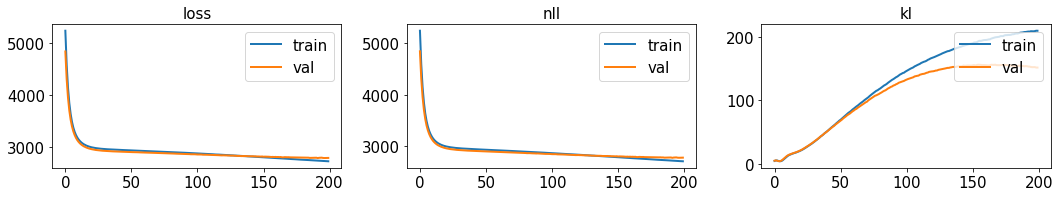

In [13]:
# diagnostics
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)
plt.tight_layout()
plt.show()

In [173]:
# torch.save(model.state_dict(), './pretrained/sim_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/sim_vae_pretrained.mod'))

<All keys matched successfully>

In [14]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

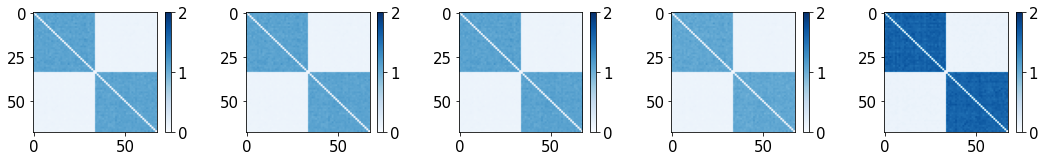

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 5, replace=False)]):
    p = axes[i].imshow(x, aspect='auto', cmap='Blues', vmin=0, vmax=2)
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [16]:
big_noise_recon = x_recon[np.arange(n_noisy_nets)]
small_noise_recon = x_recon[np.arange(n_noisy_nets, n_nets)]
diff_noise_recon= small_noise_recon.mean(0) - big_noise_recon.mean(0)

In [17]:
pca = PCA(2)
vae_Xt = pca.fit_transform(vae_latents)
vae_df = pd.DataFrame({"pc1": vae_Xt[:,0], "pc2": vae_Xt[:,1], "noise": noises})

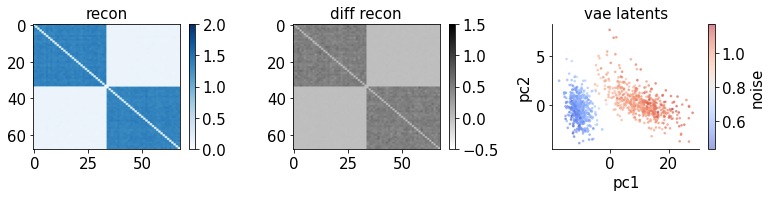

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))

p1 = axes[0].imshow(x_recon.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0].set_title('recon')
cbar = plt.colorbar(p1, ax=axes[0])

p2 = axes[1].imshow(diff_noise_recon, aspect='auto', cmap='binary', vmin=-0.5, vmax=1.5)
axes[1].set_title('diff recon')
cbar = plt.colorbar(p2, ax=axes[1])

p3 = axes[2].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=vae_df, s=3, alpha=0.5)
axes[2].set_xlabel('pc1')
axes[2].set_ylabel('pc2')
axes[2].set_title('vae latents')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[2], label="noise")

plt.tight_layout()
plt.show()

inv_vae

In [31]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=1,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    alpha = 11., beta = 1., gamma = 10., add_reg = False, y_dim = 0, 
    batch_size=32, n_epochs=200, lr=2e-6, device=DEVICE)

In [32]:
inv_model = INV_VAE(config).to(config.device)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [33]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.custom_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.custom_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 56456.156 nll: 5131.801 kl: 5.008 inv_loss: 0.134
epoch: 0 test loss 52531.657 nll: 4775.012 kl: 4.980 inv_loss: 0.154
epoch: 5 train loss: 38543.289 nll: 3502.278 kl: 15.362 inv_loss: 0.287
epoch: 5 test loss 37598.539 nll: 3416.209 kl: 16.960 inv_loss: 0.328
epoch: 10 train loss: 34705.669 nll: 3152.081 kl: 28.167 inv_loss: 0.461
epoch: 10 test loss 34186.911 nll: 3104.823 kl: 28.991 inv_loss: 0.486
epoch: 15 train loss: 33403.814 nll: 3032.514 kl: 39.894 inv_loss: 0.627
epoch: 15 test loss 32981.633 nll: 2994.036 kl: 40.714 inv_loss: 0.652
epoch: 20 train loss: 32820.248 nll: 2978.259 kl: 51.443 inv_loss: 0.796
epoch: 20 test loss 32433.597 nll: 2943.056 kl: 51.918 inv_loss: 0.806
epoch: 25 train loss: 32506.964 nll: 2948.470 kl: 63.920 inv_loss: 0.987
epoch: 25 test loss 32140.644 nll: 2915.155 kl: 64.092 inv_loss: 0.984
epoch: 30 train loss: 32298.912 nll: 2928.260 kl: 76.166 inv_loss: 1.188
epoch: 30 test loss 31943.404 nll: 2896.026 kl: 75.574 inv_loss: 1.15

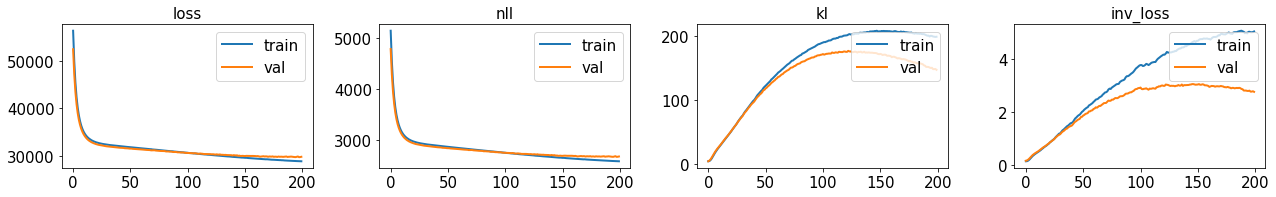

In [34]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [35]:
# torch.save(inv_model.state_dict(), './pretrained/sim_inv_vae_pretrained.mod')
# inv_model.load_state_dict(torch.load('./pretrained/sim_inv_vae_pretrained.mod'))

In [36]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()
x_denoised = inv_model.decode(z_sample, 
                      torch.ones_like(tensor_noises).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

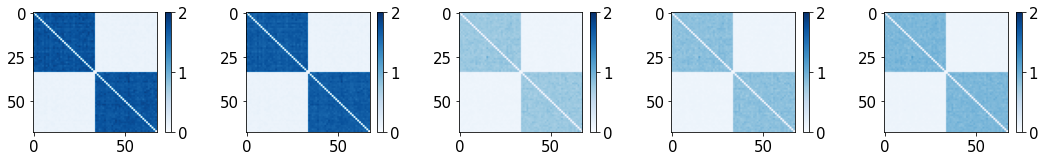

In [37]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2.5))
for i, x in enumerate(x_denoised[np.random.choice(ids, 5, replace=False)]):
    p = axes[i].imshow(x, aspect='auto', cmap='Blues', vmin=0, vmax=2)
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [38]:
big_noise_denoised = x_denoised[np.arange(n_noisy_nets)]
small_noise_denoised = x_denoised[np.arange(n_noisy_nets, n_nets)]
diff_noise_denoised = small_noise_denoised.mean(0) - big_noise_denoised.mean(0)

In [39]:
pca = PCA(2)
inv_vae_Xt = pca.fit_transform(inv_latents)
inv_vae_df = pd.DataFrame({"pc1": inv_vae_Xt[:,0], "pc2": inv_vae_Xt[:,1], "noise": noises})

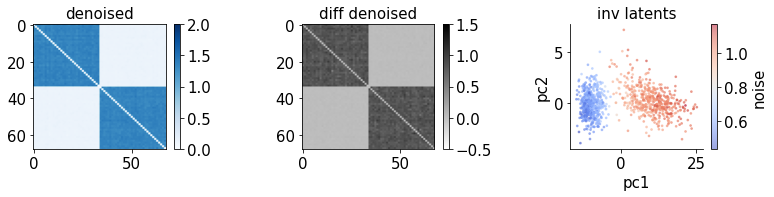

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))

p1 = axes[0].imshow(x_denoised.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0].set_title('denoised')
cbar = plt.colorbar(p1, ax=axes[0])

p2 = axes[1].imshow(diff_noise_denoised, aspect='auto', cmap='binary', vmin=-0.5, vmax=1.5)
axes[1].set_title('diff denoised')
cbar = plt.colorbar(p2, ax=axes[1])

p3 = axes[2].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=inv_vae_df, s=3, alpha=0.5)
axes[2].set_xlabel('pc1')
axes[2].set_ylabel('pc2')
axes[2].set_title('inv latents')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[2], label="noise")

plt.tight_layout()
plt.show()